In [1]:
#importing the relevant packages
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'
from countrygroups import EUROPEAN_UNION
import seaborn as sns
from scipy import stats

Loading in the datasets and assigning them to data frames

In [2]:
dataset1=pd.read_csv('GlobalLandTemperaturesByCity.csv',index_col=['dt'])
df_city=pd.DataFrame(dataset1)
df_city=df_city.reset_index()

dataset2 = pd.read_csv('GlobalLandTemperaturesByCountry.csv',index_col=['dt'])
df_country=pd.DataFrame(dataset2)
df_country=df_country.reset_index()


Custom function defined to perform data cleaning by filling blank values with the average value for respective month

In [3]:
def cleaning_data(df):

    #casting date field to datetime format to utilise .dt.month attribute
    df['dt'] = pd.to_datetime(df['dt'])
    #creating a dictionary of the fields with null values
    dictionary = (df.isna().any()==True).to_dict()
    
    #iterating through the dictionary to find where True
    for col,val in dictionary.items():
        if val == True:                  
            #creating a dataframe of the null values
            null_df = df[df.isna()[col]==True]
            
            #iterating through the null values and getting the mean for each month
            for i in null_df.index:
                month = df.loc[i,'dt'].to_pydatetime().month
                mean = df[df["dt"].dt.month == month].dropna()[col].mean()
                df.at[i,col]=mean

# Plotting the EU countries in rank of average temperature

In [4]:
#using the countrygroups package to import the names of all EU countries
EU_list = EUROPEAN_UNION.names
#renaming Czechia to Czech Republic
EU_list[5] = 'Czech Republic'

#performing more data cleaning; repacing values with "(Europe)" appended on
df_country['Country'].replace({'France (Europe)':'France','Denmark (Europe)':'Denmark','Netherlands (Europe)':'Netherlands','United Kingdom (Europe)':'Europe'},inplace=True)
continents = ['North America','South America','Asia','Africa','Europe']

#dataframe contains continents; need to remove these
df_country=df_country[~df_country['Country'].isin(continents)]

df_EU = df_country.set_index('Country').loc[EU_list,:].reset_index()


In [5]:
#utilising data cleaning custom function
cleaning_data(df_EU)

In [6]:
df_EU=df_EU[df_EU['Country']!='Denmark']

In [7]:
#grouping by means
df_err = df_EU.groupby('Country')['AverageTemperatureUncertainty'].mean()
df_EU = df_EU.groupby('Country')['AverageTemperature'].mean()
df_EU = df_EU.reset_index()

#joining averages and their corresponding uncertainties 
df_EU = df_EU.merge(df_err,left_on='Country',right_on='Country',how='right')

#sorting dataframe
df_EU = df_EU.sort_values(by='AverageTemperature',ascending=False)


In [8]:
df_EU

,Country,AverageTemperature,AverageTemperatureUncertainty
4,Cyprus,18.776836,1.006125
17,Malta,18.493579,1.449880
20,Portugal,14.688100,1.447690
10,Greece,14.646601,1.463677
24,Spain,13.512571,1.433661
13,Italy,12.656596,1.477725
8,France,11.539477,1.556118
3,Croatia,11.293308,1.553552
2,Bulgaria,10.453246,1.560515
11,Hungary,9.709842,1.572034


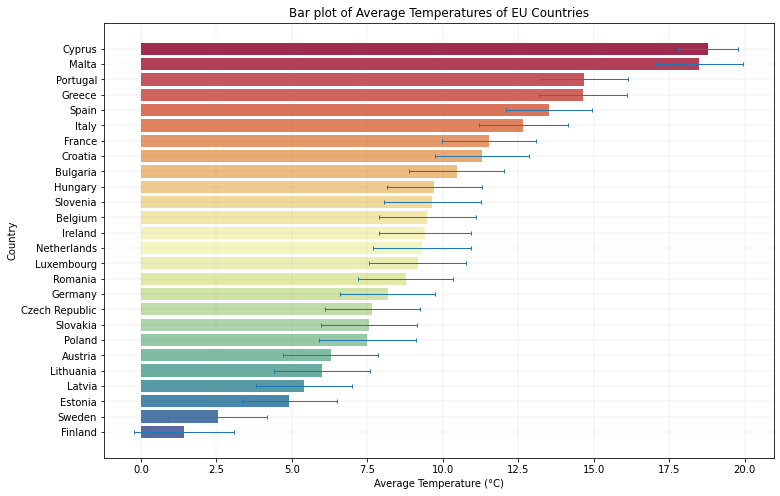

In [9]:
fig,ax = plt.subplots(figsize=(12,8))
ax = sns.barplot(x='AverageTemperature',y='Country',data=df_EU,palette="Spectral")

ax.errorbar(df_EU['AverageTemperature'],df_EU['Country'],xerr=df_EU['AverageTemperatureUncertainty'],
            elinewidth=1,capsize = 2,fmt = ' ')

ax.set_title('Bar plot of Average Temperatures of EU Countries')
plt.xticks(np.arange(0, 22, 2.5))
plt.grid(color='gray', linestyle='-', linewidth=0.1)
ax.set_xlabel('Average Temperature (°C)')
plt.savefig('EUTemp.png', bbox_inches='tight')
plt.show()


In [10]:
#df_EU = df_EU.groupby('Country')['AverageTemperature'].mean()
EU_list = EUROPEAN_UNION.names
EU_list[5] = 'Czech Republic'

df_country['Country'].replace({'France (Europe)':'France','Denmark (Europe)':'Denmark','Netherlands (Europe)':'Netherlands','United Kingdom (Europe)':'Europe'},inplace=True)

df_EU = df_country.set_index('Country').loc[EU_list,:].reset_index()


# Temperatures Difference Comparison

The aim of this part is to show which countries have experienced the largest/smallest net temperature changes over the past 100 years

In [11]:
dataset2 = pd.read_csv('GlobalLandTemperaturesByCountry.csv',index_col=['dt'])
df_country=pd.DataFrame(dataset2)
df_country=df_country.reset_index()

In [12]:
dfcountry=df_country['Country'].replace({'France (Europe)':'France','Denmark (Europe)':'Denmark',
                                         'Netherlands (Europe)':'Netherlands','United Kingdom (Europe)':'Europe'},
                                        inplace=True)
df_All = df_country
df_All['dt'] = pd.to_datetime(df_All['dt'])
df_All['Year'] = df_All['dt'].dt.year

#only selecting out data after 1900 (for more accurate comparisons)
df_All = df_All[df_All['Year']>=1900]


Using a dictionary to initialise a blank dataframe to be appended to

In [13]:
Country = []
diff =  []
new_dict = {'Country':Country, 'TempDiff':diff}
df = pd.DataFrame(new_dict)

Iterating through the dataframe by each unique country

In [14]:
#concating all average temperatures per year for each country

for country in df_All['Country'].unique():
    df_new = df_All.set_index('Country').loc[country,:]
    
    df_err = df_new.groupby('Year')['AverageTemperatureUncertainty'].mean()
    df_new = df_new.groupby('Year')['AverageTemperature'].mean()
    df_new =df_new.reset_index()
    df_err= df_err.reset_index()
    df_new = df_new.dropna()
    
    #remove any obvious outliers (i.e more than 2.5 std away from the mean of the dataset)
    df_new=df_new[(np.abs(stats.zscore(df_new['AverageTemperature'])) < 2.5)]
    
    #getting the average temperatures across the first 50 and last 50 years in dataset for each country
    first_50 = df_new.sort_values(by='Year',ascending=True)[:50]
    first_50 = first_50['AverageTemperature'].mean()
    
    last_50 = df_new.sort_values(by='Year',ascending=False)[:50]
    last_50 = last_50['AverageTemperature'].mean()
    
    #calculating the difference between the average temperatures for first/last 50 years
    difference = last_50 - first_50
    
    #creating dataframe using country and differences
    df_new = pd.DataFrame({'Country':[country,], 'TempDiff':[difference,]})
    
    #concatenting above dataframe to one we previously initialised
    df = pd.concat([df,df_new])
        

/Users/Gerard/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:2497: RuntimeWarning: Mean of empty slice.
  mns = a.mean(axis=axis, keepdims=True)
/Users/Gerard/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/Users/Gerard/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/Gerard/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/Users/Gerard/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


sorting temperature differences to determine countries with largest and smallest differences

In [15]:
bigChange = df.sort_values(by='TempDiff',ascending=False)[:10]
smallChange = df.sort_values(by='TempDiff',ascending=True)[:10]
smallChange = smallChange.sort_values(by='TempDiff',ascending=False)

In [16]:
smallChange

,Country,TempDiff
0,Togo,0.317125
0,Sao Tome And Principe,0.312767
0,Greece,0.303845
0,Congo,0.300324
0,Faroe Islands,0.266879
0,Svalbard And Jan Mayen,0.225678
0,French Southern And Antarctic Lands,0.173141
0,Greenland,0.163870
0,Heard Island And Mcdonald Islands,0.156959
0,Iceland,0.152928


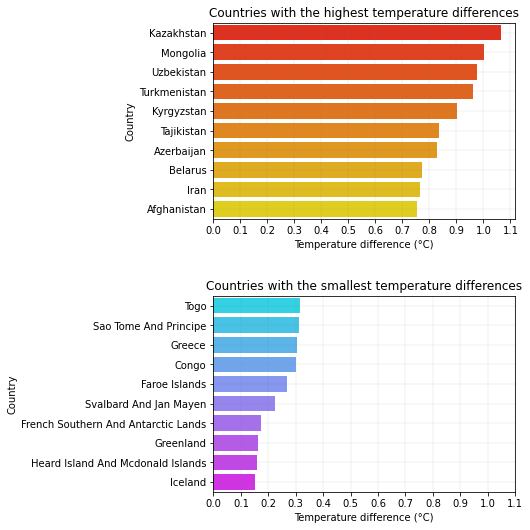

In [17]:
fig,axes = plt.subplots(2,figsize=(8,8))

ax = sns.barplot(x='TempDiff',y='Country',data=bigChange,palette="autumn",ax=axes[0])

ax1 = sns.barplot(x='TempDiff',y='Country',data=smallChange,palette="cool",ax=axes[1])

texts = ax.set(ylabel="Country", xlabel="Temperature difference (°C)", 
               title="Countries with the highest temperature differences")

texts1 = ax1.set(ylabel="Country", xlabel="Temperature difference (°C)",
                 title="Countries with the smallest temperature differences")

ax.set_xticks(np.arange(0, 1.2, 0.1))
ax1.set_xticks(np.arange(0, 1.2, 0.1))
fig.tight_layout(pad=3.0)
ax.grid(color='gray', linestyle='-', linewidth=0.1)
ax1.grid(color='gray', linestyle='-', linewidth=0.1)
plt.savefig('highLowTemps.png', bbox_inches='tight')
#sns.barplot(x='TempDiff',y='Country',data=smallChange,palette="Spectral")

# Looking a bit closer at country with biggest change : Kazakhstan

In [18]:
#more data frame manipulation

df_one_country = df_country[df_country['Country']=='Kazakhstan']
df_one_country = df_one_country.dropna()
df_one_country['Year'] = df_one_country['dt'].dt.year
df_one_country = df_one_country.groupby('Year')['AverageTemperature'].mean()
df_one_country = df_one_country.reset_index()

#again we want to ignore obvious outliers as much as possible
df_one_country = df_one_country[(np.abs(stats.zscore(df_one_country['AverageTemperature'])) < 2.5)]

#only looking at dates after 1900
df_one_country = df_one_country[df_one_country['Year']>1900]



Here we will utilise seaborns implot to fit a regression model to kazakhstans average temperature over time. This gives us a clear picture of the obvious correlation

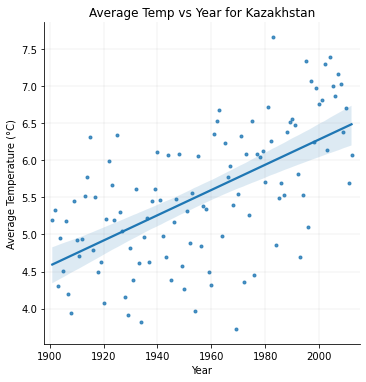

In [19]:

plot = sns.lmplot(data=df_one_country, x="Year", y="AverageTemperature",markers='.')
plot.set(xlim=(1898, 2015))
plt.ylabel('Average Temperature (°C)')
plt.grid(color='gray', linestyle='-', linewidth=0.1)
plt.title('Average Temp vs Year for Kazakhstan')
plt.savefig('Kazakhstan.png', bbox_inches='tight')
plt.show()
